# Imports

In [1]:
from configuration.paths import *

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import models, layers

from src.datasets.chest_xray import ChestXRay
from src.utils.schemes import Scheme
from src.utils.image import Image

# Dataset loading for training

In [2]:
IMAGE_SIZE = (256, 256)

In [3]:
cx = ChestXRay(DATASET_CHEST_XRAY_PATH, IMAGE_SIZE)

In [4]:
Scheme.dataset_info(cx)

Train:
 - Normal: 1341
 - Pneumonia: 1938
Test:
 - Normal: 234
 - Pneumonia: 390
Val:
 - Normal: 8
 - Pneumonia: 8


In [5]:
x_train, y_train, _ = cx.load_train_data()
x_train = x_train / 255.0

x_val, y_val, _ = cx.load_val_data()
x_val = x_val / 255.0

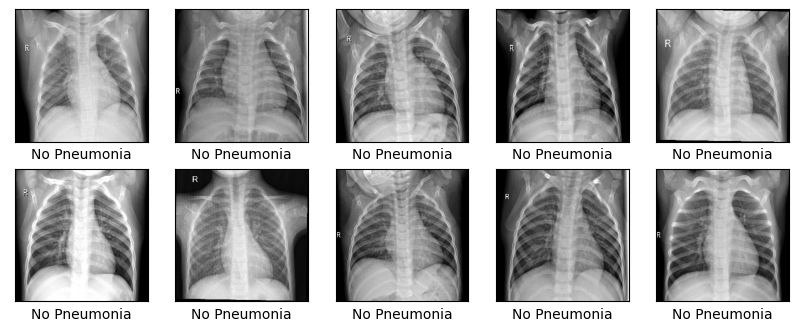

In [6]:
Scheme.labeled_images(x_train, y_train)

# Mdel definition

In [7]:
model = models.Sequential()

model.add(layers.Conv2D(filters=16, activation='relu', kernel_size=3, padding='same', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))
model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))

model.add(layers.Conv2D(filters=16, activation="relu", kernel_size=3, padding="same"))
model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))

model.add(layers.Conv2D(filters=32, activation="relu", kernel_size=3, padding="same"))
model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))

model.add(layers.Conv2D(filters=64, activation="relu", kernel_size=3, padding="same"))
model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))

model.add(layers.Conv2D(filters=128, activation="relu", kernel_size=3, padding="same"))
model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        1

In [8]:
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        1

In [9]:
model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=['binary_accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')])

# Model training

In [10]:
history = model.fit(x=x_train,
                    y=y_train,
                    validation_data=(x_val, y_val),
                    epochs=15)

Epoch 1/15
103/103 [==============================] - 6s 34ms/step - loss: 0.5681 - binary_accuracy: 0.6921 - precision: 0.7240 - recall: 0.7872 - val_loss: 0.3945 - val_binary_accuracy: 0.7500 - val_precision: 0.7000 - val_recall: 0.8750
Epoch 2/15
103/103 [==============================] - 2s 23ms/step - loss: 0.2131 - binary_accuracy: 0.9197 - precision: 0.9480 - recall: 0.9125 - val_loss: 0.6900 - val_binary_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 3/15
103/103 [==============================] - 2s 23ms/step - loss: 0.0927 - binary_accuracy: 0.9736 - precision: 0.9790 - recall: 0.9764 - val_loss: 0.3752 - val_binary_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 4/15
103/103 [==============================] - 2s 23ms/step - loss: 0.1250 - binary_accuracy: 0.9603 - precision: 0.9662 - recall: 0.9666 - val_loss: 0.2532 - val_binary_accuracy: 0.8750 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 5/15
103/103 [========================

<Figure size 640x480 with 0 Axes>

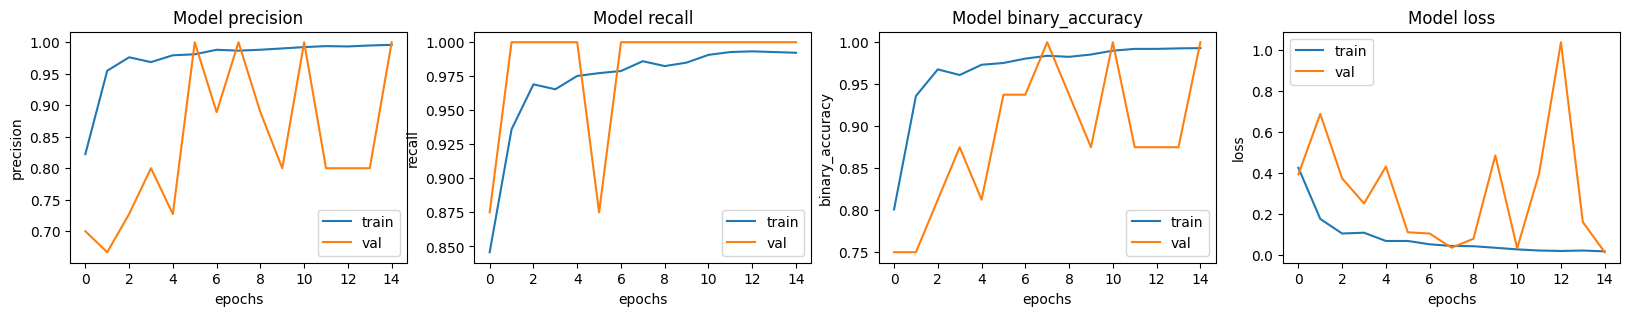

In [11]:
Scheme.training_graphs(history)

In [12]:
del x_train
del y_train

# Evaluating the model

In [13]:
x_test, y_test, images = cx.load_test_data()
x_test = x_test / 255.0

In [14]:
test_loss, test_accuracy, _, _ = model.evaluate(x_test, y_test)

20/20 [==============================] - 0s 15ms/step - loss: 2.1498 - binary_accuracy: 0.7901 - precision: 0.7515 - recall: 0.9923


In [15]:
predictions = model.predict(x_test)
predictions_rounded = np.round(predictions).astype(int)

In [16]:
images_index = [9, 11, 12, 13, 16, 1, 2, 3, 5, 8]
images = [x_test[img] for img in images_index]
labels = [y_test[img] for img in images_index]
predicted_images = [predictions_rounded[img][0] for img in images_index]

Before explaining the images

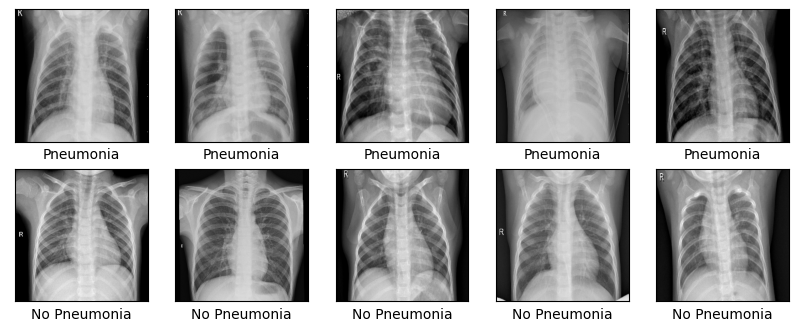

In [17]:
Scheme.labeled_images(images, labels)

Explain the images

In [18]:
explained_images = Image.explain(images, model, IMAGE_SIZE)

100%|██████████| 1000/1000 [00:07<00:00, 131.64it/s]


Green regions -> Supporting the predicted label

Red regions -> Against the predicted label

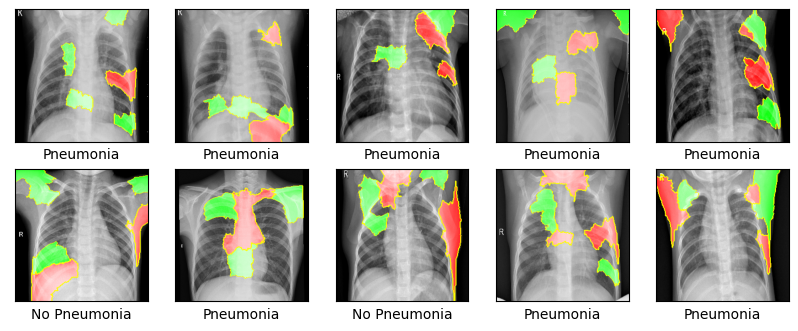

In [19]:
Scheme.labeled_images(explained_images, predicted_images)

<Figure size 640x480 with 0 Axes>

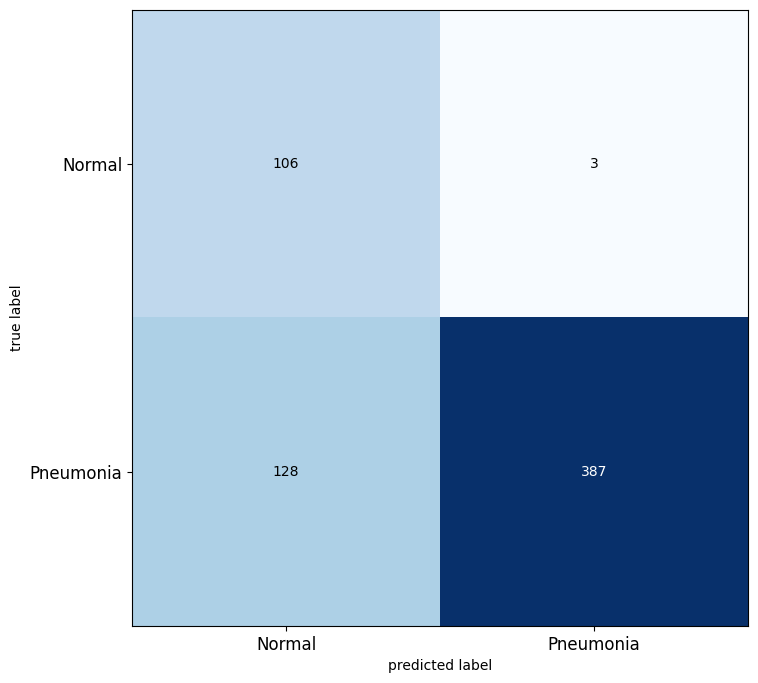

In [20]:
Scheme.confusion_matrix(predictions_rounded, cx.get_test_df().diagnosis.to_numpy())